In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import theano
import theano.tensor as T
import lasagne as L

from IPython import display

from util import *
from rosenbrock import RosenbrockFunction_Tensor

Using gpu device 1: Tesla K40m (CNMeM is disabled, cuDNN 5105)


In [2]:
%run ../lstm_optimizer_params.py
%run ../ntm_bfgs_optimizer_params.py
%run ../chain_optimizer.py

In [3]:
#A = T.scalar()
#B = T.scalar()
A = T.vector('A')
B = T.vector('B')

func = lambda theta, A, B: RosenbrockFunction_Tensor(theta, A, B).func

In [4]:
options = {
    'num_units': 20,
    'function': func,
    'n_layers': 2,
    'preprocess_input': False,
    'gradient_steps': 20,
    'gradient_clipping': 1,
    'loglr': True,
}

In [5]:
def sample_point(ndim=2, *args):
    return np.zeros(2)

def sample_point_second_phase(ndim=2, a=None, b=None):
    return np.array([a, a**2]) + 0.01 * np.random.uniform(low=-1, high=1, size=2)

def sample_params(ndim=None, *args):
    a = np.random.uniform(low=-3, high=3)
    b = np.random.uniform(20, 100)
    return a, b

def sample_point_and_params(ndim=None, sample_point=sample_point):#_second_phase):
    a, b = sample_params(ndim)
    theta = sample_point(ndim, a, b)
    
    return theta, (a, b)

def grid_sampler(low, high, num=100):
    d = (high - low) / num
    x = np.linspace(low, high, num)
    y = np.linspace(low, high, num)
    xv, yv = np.meshgrid(x, y)
    return [(np.array([xv[i, j], yv[i, j]]), sample_params()) for i in range(num) for j in range(num)]

def grid_sampler_2(n_functions, dx, dy, num=100):
    problems = []
    for _ in range(n_functions):
        a, b = sample_params()
        x = np.linspace(a - dx, a + dx, num)
        y = np.linspace(a**2 - dy, a**2 + dy, num)
        xv, yv = np.meshgrid(x, y)
        problems += [(np.array([xv[i, j], yv[i, j]]), a, b) for i in range(num) for j in range(num)]
    return list(map(np.array, zip(*problems)))

def multisampler(n, *args):
    A = np.random.uniform(low=-3, high=3, size=n)
    B = np.random.uniform(20, 100, size=n)
    theta = np.zeros((n, 2))
    return theta, A, B

In [6]:
options['n_gac'] = 0
n_opt = 7
opts = [LSTM_Optimizer(scale_output=2**(-i), params_input=[A, B], **options) for i in range(n_opt)]
chain_optimizer = ChainOptimizer(opts, n_small_steps=20)

In [7]:
chain_optimizer.prepare(loss_type='sum', start_lr=0.001)

Time compiling value_fn: 0.3521709442138672
Time compiling loss_fn: 4.561622142791748
Time compiling train_fn: 90.76321053504944
Time compiling value_fn: 0.11692118644714355
Time compiling loss_fn: 3.0393311977386475
Time compiling train_fn: 94.64616894721985
Time compiling value_fn: 0.13795781135559082
Time compiling loss_fn: 2.914632558822632
Time compiling train_fn: 100.75440907478333
Time compiling value_fn: 0.13017868995666504
Time compiling loss_fn: 2.9387197494506836
Time compiling train_fn: 93.23803663253784
Time compiling value_fn: 0.11627793312072754
Time compiling loss_fn: 6.292706727981567
Time compiling train_fn: 93.28829956054688
Time compiling value_fn: 0.11347031593322754
Time compiling loss_fn: 2.9292798042297363
Time compiling train_fn: 92.30848741531372
Time compiling value_fn: 0.12419629096984863
Time compiling loss_fn: 4.292449474334717
Time compiling train_fn: 94.22060203552246


In [8]:
val_inputs = multisampler(8000)

In [9]:
n_epochs   = 30
batch_size = 400

training_options = {
    'n_epochs'  : n_epochs,
    'batch_size': batch_size,
    'decay_rate': 1.0,
    'verbose': True
}

iterations = [20]
n_functions = n_epochs * batch_size

In [10]:
from rosenbrock import RosenbrockFunction

AA = T.scalar('a')
BB = T.scalar('b')
func_ = lambda theta: RosenbrockFunction(theta, AA, BB).func

sgd_fn = make_sgd(func_, var=[AA, BB])
momentum_fn = make_momentum(func_, var=[AA, BB])
lbfgs_fn = make_lbfgs(func_, m=10, init_lr=2e-4, var=[AA, BB])

non_lstm_optimizers = {
    'sgd': sgd_fn,
    'momentum': momentum_fn, 
    'lbfgs': lbfgs_fn
}

In [23]:
train_inputs = multisampler(3000)

new_partition = None

p = 0

for theta, a, b in zip(*train_inputs):
    lbfgs_thetas, lbfgs_losses = lbfgs_fn(theta, 100, a, b, 1.0)

    if lbfgs_losses[-1] > 1e-3:
        print(a, a**2, lbfgs_thetas[-1], lbfgs_losses[-1])
    
    partition = get_partition(
        (lbfgs_thetas, 
         np.tile(a, (lbfgs_thetas.shape[0],)), 
         np.tile(b, (lbfgs_thetas.shape[0],))
        ),
        lbfgs_losses, 
        #[1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8], filter_empty=False,
        [1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10], filter_empty=False,
    )
    
    if new_partition:
        for i in range(len(new_partition)):
            for j, k in enumerate(partition[i]):
                new_partition[i][j] = np.concatenate([new_partition[i][j], k], axis=0)
    else:
        new_partition = [list(p) for p in partition]

    if p % 100 == 0:
        print(p)
    p += 1
    
    
for i in range(len(new_partition)):
    indices = np.arange(len(new_partition[i][0]))
    np.random.shuffle(indices)
    
    for j in range(len(new_partition[i])):
        new_partition[i][j] = new_partition[i][j][indices][:8000]

0
2.86951615058 8.23412293841 [ 0.4234637   0.14461434] 6.10248
2.95734656364 8.74589869748 [ 0.43548402  0.14281578] 6.54718
-2.98267793494 8.8963676636 [-0.42693543  0.14029752] 6.68198
2.84147511664 8.0739808385 [ 0.42047256  0.13913147] 5.99255
100
-2.78715745936 7.76824670329 [-0.4299221   0.14355651] 5.72048
200
-2.92772716939 8.57158637838 [-0.41499016  0.14140864] 6.40336
0.20883557734 0.0436122983629 [ 0.26713791  0.07411586] 0.00405537
-2.61668088379 6.84701884761 [-1.67550385  2.81887865] 0.897909
300
-2.90397852511 8.43309127432 [-0.4087126   0.13540037] 6.32069
-2.78333733355 7.74696671234 [-0.4289766   0.14343962] 5.70418
2.91259716355 8.48322223713 [ 0.67176259  0.45722485] 5.02434
400
2.87998713732 8.29432591111 [ 1.96897376  3.87135339] 0.832168
2.82581740973 7.98524403313 [ 0.4368366   0.14546815] 5.89573
500
2.93267290421 8.60057036308 [ 0.41995043  0.14247029] 6.42286
2.82262177051 7.96719365938 [ 0.42088535  0.14035684] 5.89539
2.84695021598 8.10512553226 [ 0.42467

In [24]:
for p in new_partition:
    print(p[0].shape)

(8000, 2)
(8000, 2)
(8000, 2)
(4825, 2)
(3730, 2)
(1889, 2)
(1366, 2)


In [25]:
losses = []
for i in range(n_opt):
    chain_optimizer.opts[i].lr.set_value(0.005)
    chain_optimizer.opts[i].reset_network()
    
    training_options['n_iter'] = 20
    current_value = 10**(-i)

    loss, val_loss = chain_optimizer.opts[i].train(tuple(new_partition[i]), val_inputs, **training_options)
    #loss, train_inputs, val_loss = chain_optimizer.opts[j].train_remember_problems(tuple(new_problems), val_inputs, **training_options)
    losses.append((loss, val_loss))
        
#     opt_loss, val_loss = chain_optimizer.opts[j].train(new_partition[j], val_inputs, **training_options)
#     losses.append((loss, val_loss))

Epoch number 0
	Time: 3.075382709503174
	Optimizer loss: 8669857.951623047
	Median final loss: 29.299514770507812
	Validation loss: 26895.784249999997
Epoch number 1
	Time: 3.17034912109375
	Optimizer loss: 7948729.535667969
	Median final loss: 60.951324462890625
	Validation loss: 315.66792480468746
Epoch number 2
	Time: 3.1162266731262207
	Optimizer loss: 20609582.04236914
	Median final loss: 16.641387939453125
	Validation loss: 6082.864968750002
Epoch number 3
	Time: 3.1189658641815186
	Optimizer loss: 12329846.84184375
	Median final loss: 214.69961547851562
	Validation loss: 4716.3330000000005
Epoch number 4
	Time: 3.136815071105957
	Optimizer loss: 10761304.0345
	Median final loss: 267.13079833984375
	Validation loss: 13843.386937500001
Epoch number 5
	Time: 3.1321544647216797
	Optimizer loss: 6862774.911593748
	Median final loss: 67.97493743896484
	Validation loss: 3523.0373437499998
Epoch number 6
	Time: 3.0121352672576904
	Optimizer loss: 7055024.018218751
	Median final loss: 54

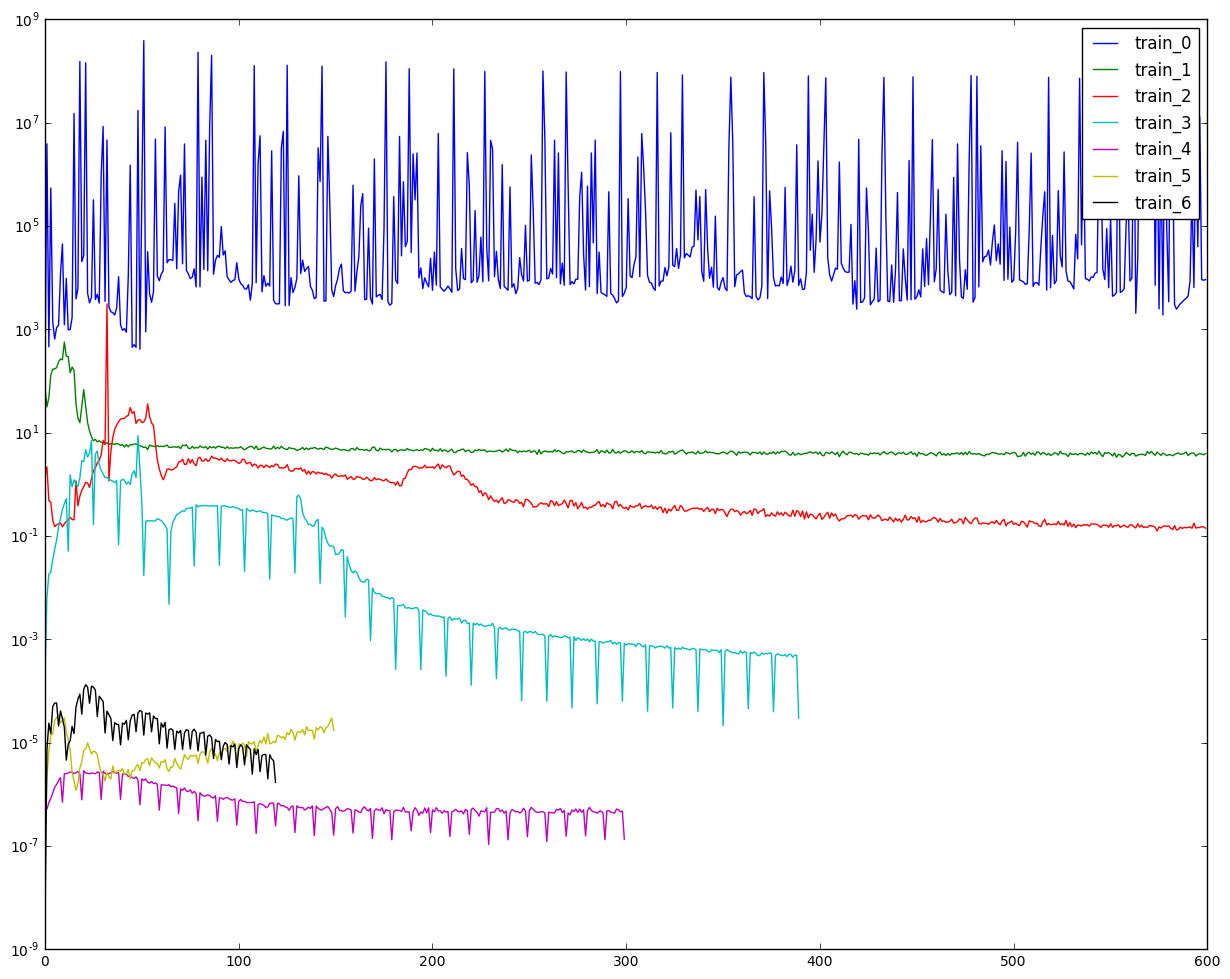

In [26]:
plt.figure(figsize=(15, 12))
for k, (train_loss, val_loss) in enumerate(losses):
    plt.semilogy(train_loss, label='train_{}'.format(k))
#     plt.semilogy(np.arange(len(val_loss)) * 20, val_loss, label='val_{}'.format(k))
plt.legend();

In [27]:
lstm_optimizers = {'chain': chain_optimizer}

In [16]:
from collections import namedtuple
TestCase = namedtuple('TestCase', 'n_iter n_functions')

In [28]:
tests = [
    TestCase(n_iter=20, n_functions=50), 
    TestCase(n_iter=60, n_functions=50),
    TestCase(n_iter=500, n_functions=50),
    TestCase(n_iter=500, n_functions=1)
]

tests_results = []

for n_iter, n_functions in tests:
    testing_options = {
        'n_iter'     : n_iter,
        'n_functions': n_functions,
        'sampler'    : multisampler,
        'normalize': True
    }
    histories = test_optimizers(lstm_optimizers, non_lstm_optimizers, **testing_options)
    tests_results.append(histories)

Testing lstm; chain
Testing lbfgs
Testing sgd
Testing momentum
Testing lstm; chain
Testing lbfgs
Testing sgd
Testing momentum
Testing lstm; chain
Testing lbfgs
Testing sgd
Testing momentum
Testing lstm; chain
Testing lbfgs
Testing sgd
Testing momentum


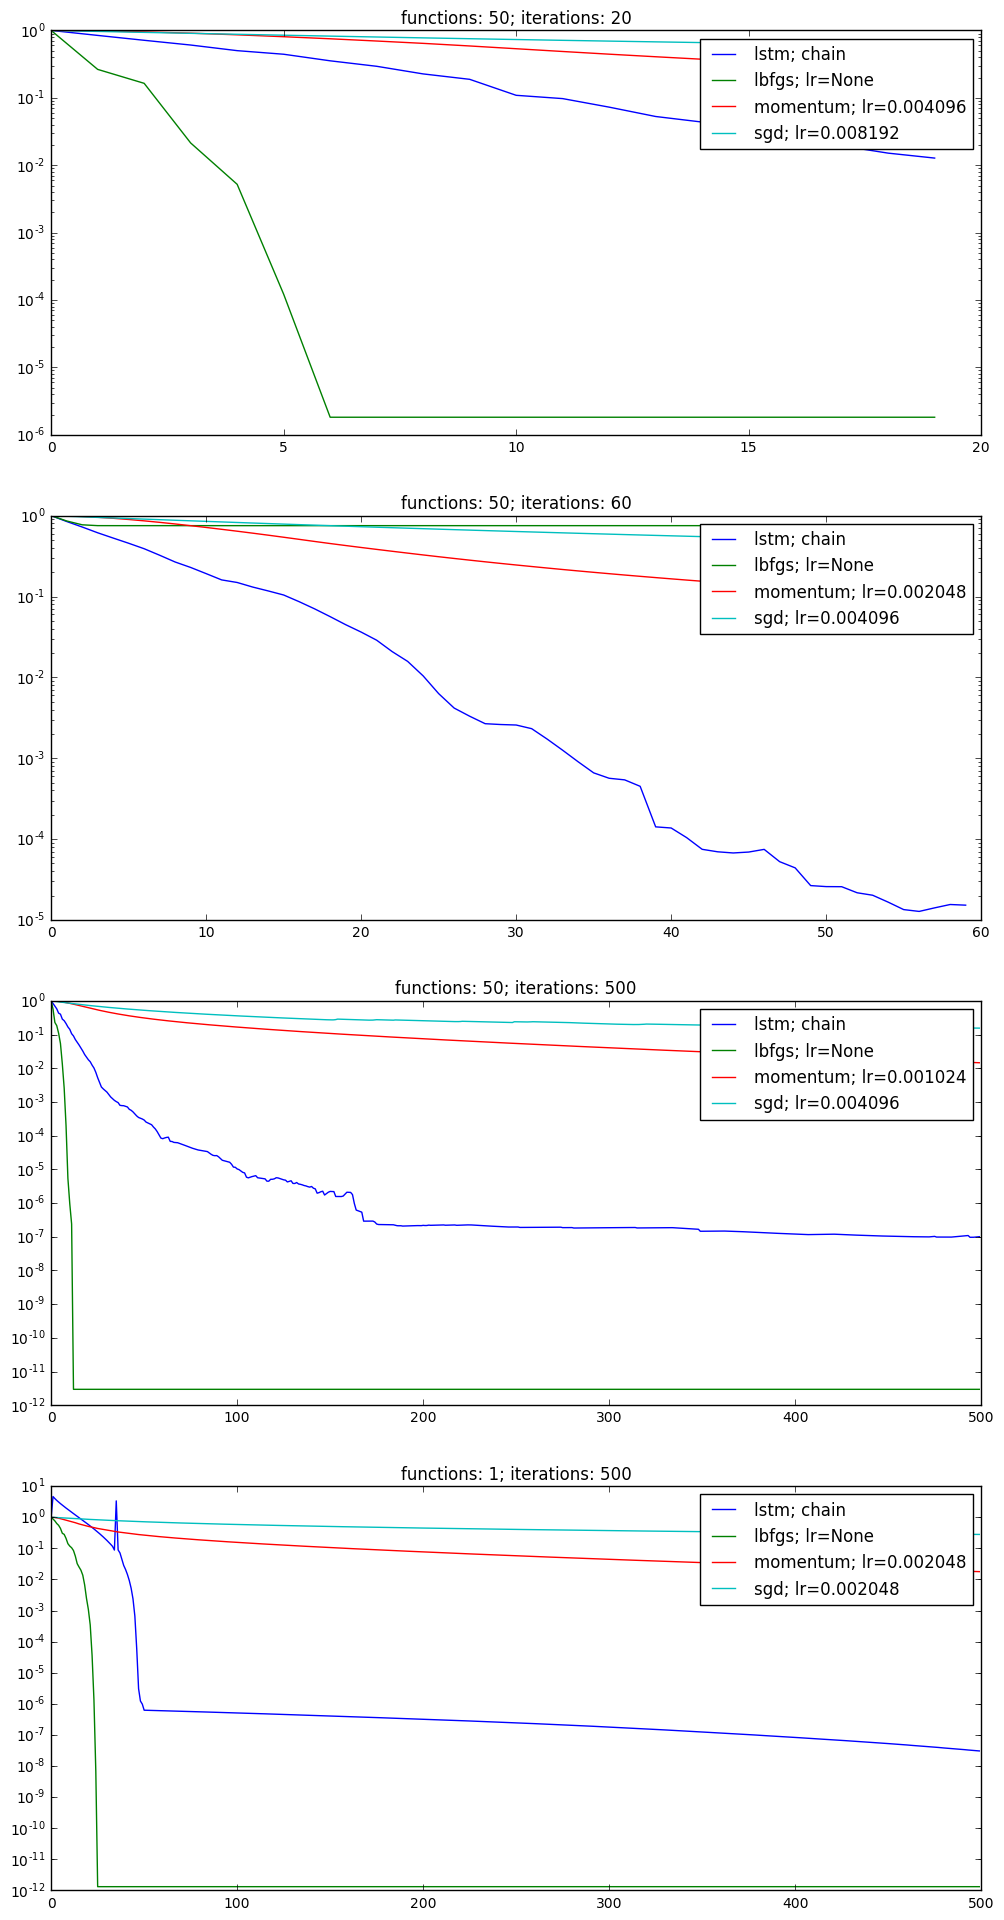

In [29]:
%matplotlib inline
fig, axes = plt.subplots(len(tests_results), figsize=(12, 6 * len(tests_results)))

if len(tests_results) == 1:
    axes = (axes,)

for ax, (n_iter, n_functions), h in zip(axes, tests, tests_results):
    for name, hist in h.items():
        ax.semilogy(hist, label=name)
    
    ax.set_title('functions: {}; iterations: {}'.format(n_functions, n_iter))
    ax.legend()
    
# fig.tight_layout()

(-0.2102300655680498, 0.044196680468746516)


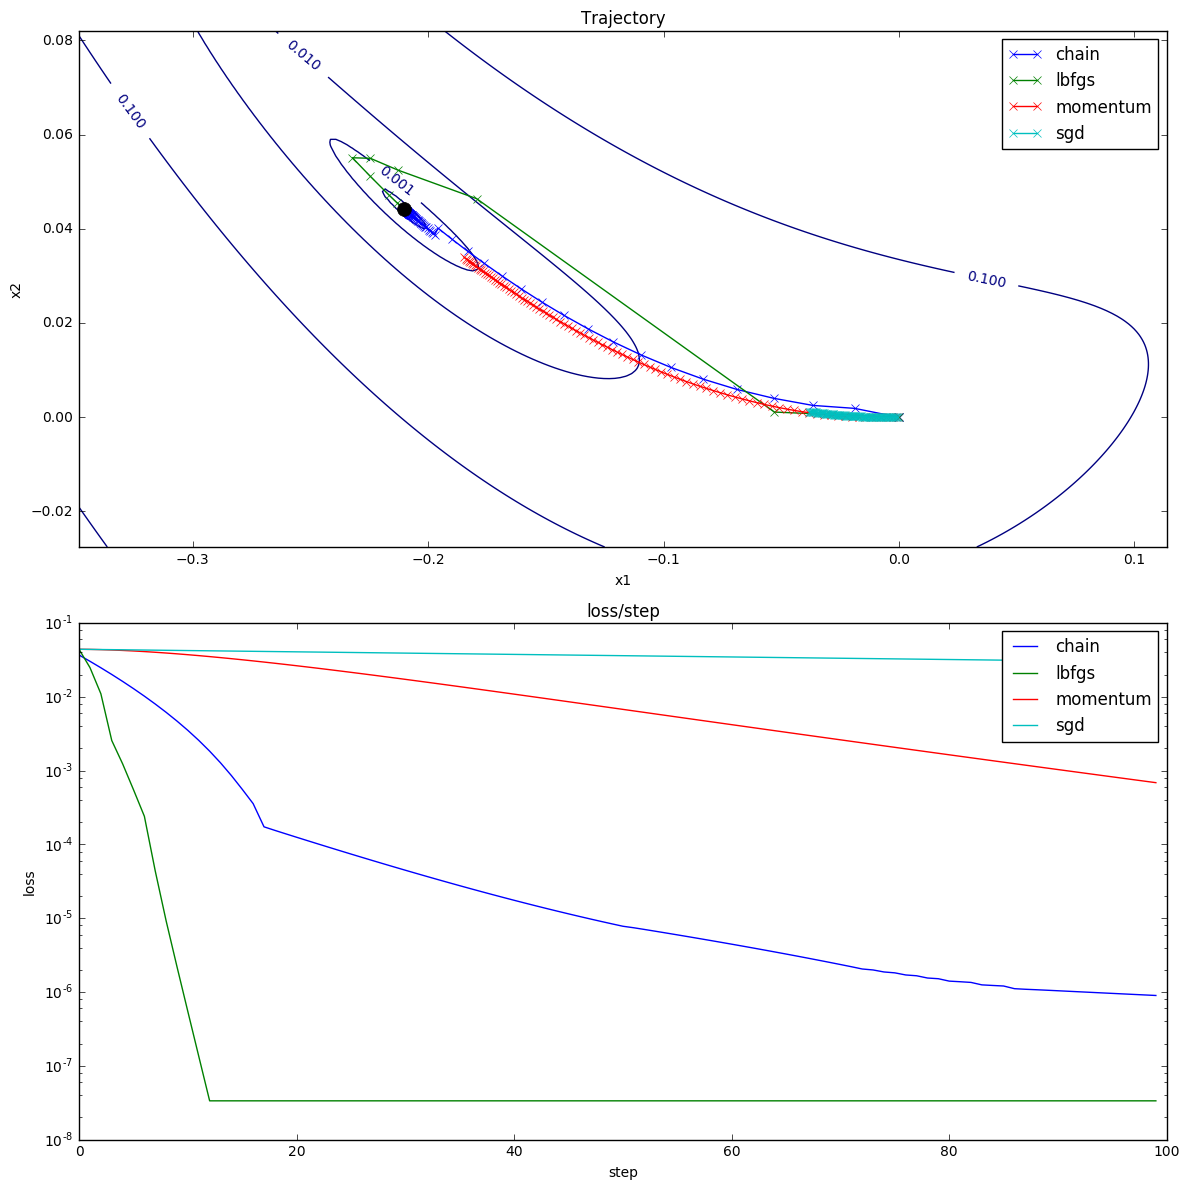

In [30]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point), lstm_optimizers, non_lstm_optimizers)

(1.1494903774225866, 1.3213281277871207)


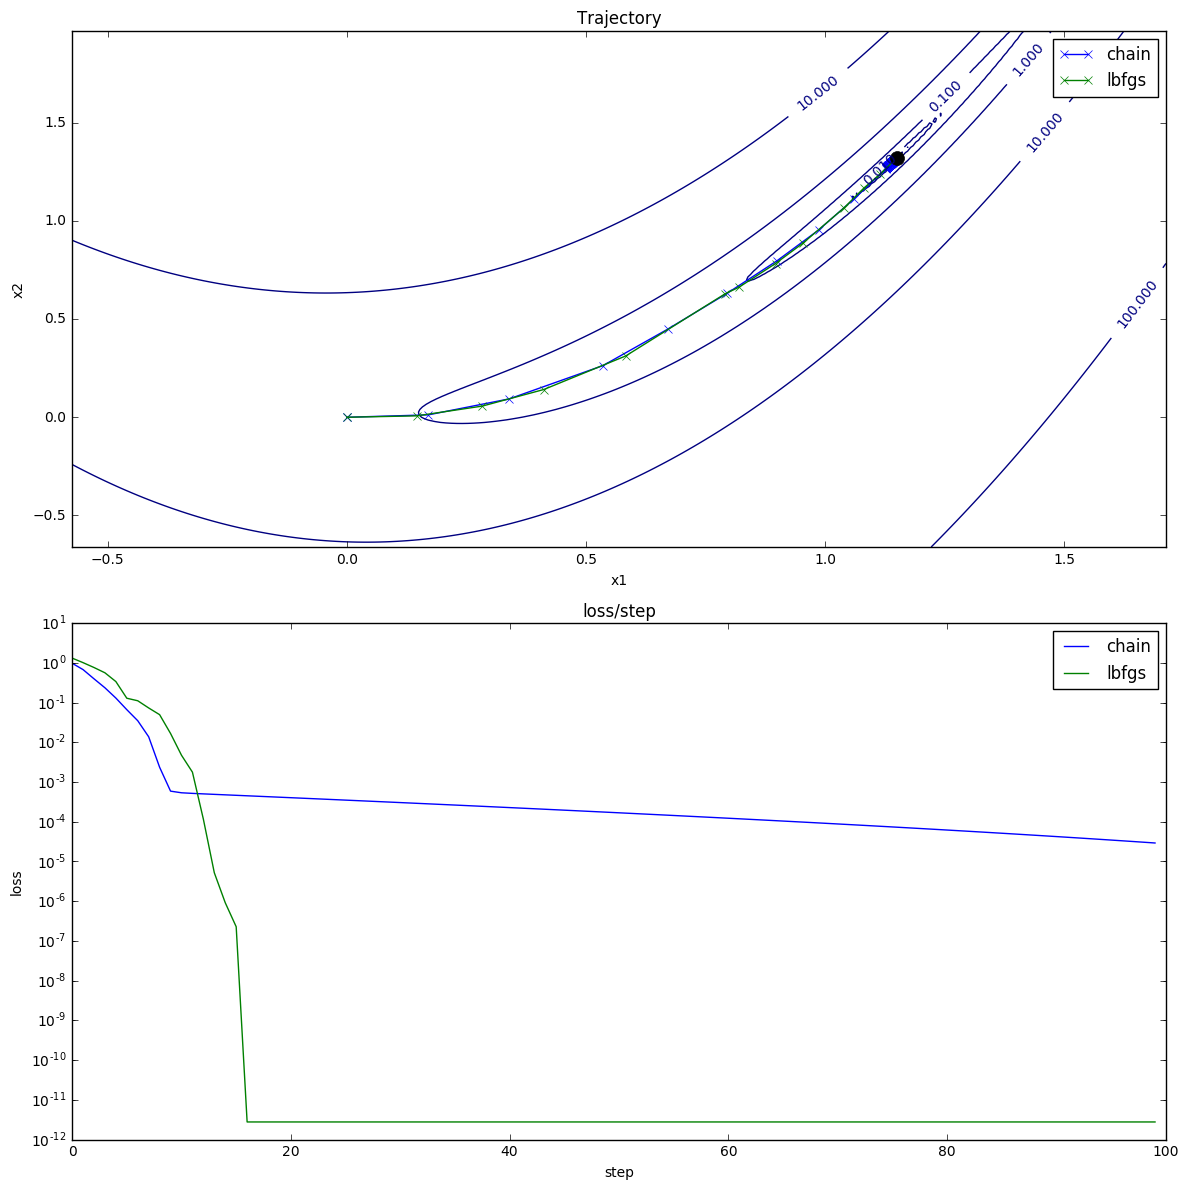

In [31]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point), lstm_optimizers, {k: v for k, v in non_lstm_optimizers.items() if k == 'lbfgs'})

(0.03977828440512354, 0.0015823119102148949)


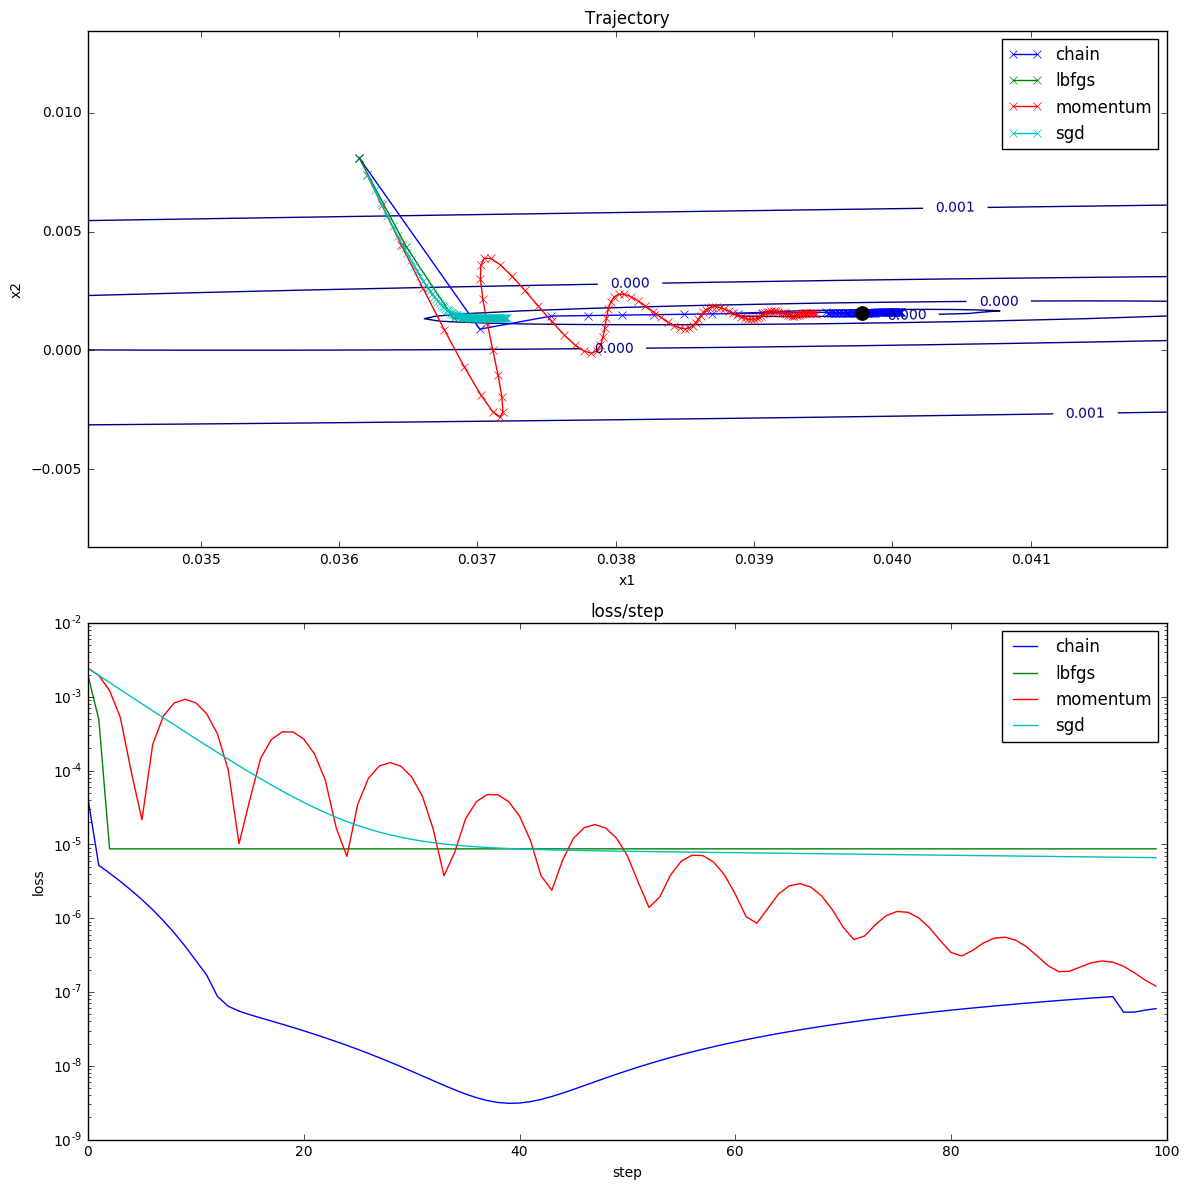

In [32]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point_second_phase), lstm_optimizers, non_lstm_optimizers)

(-2.227920990426286, 4.963631939582043)


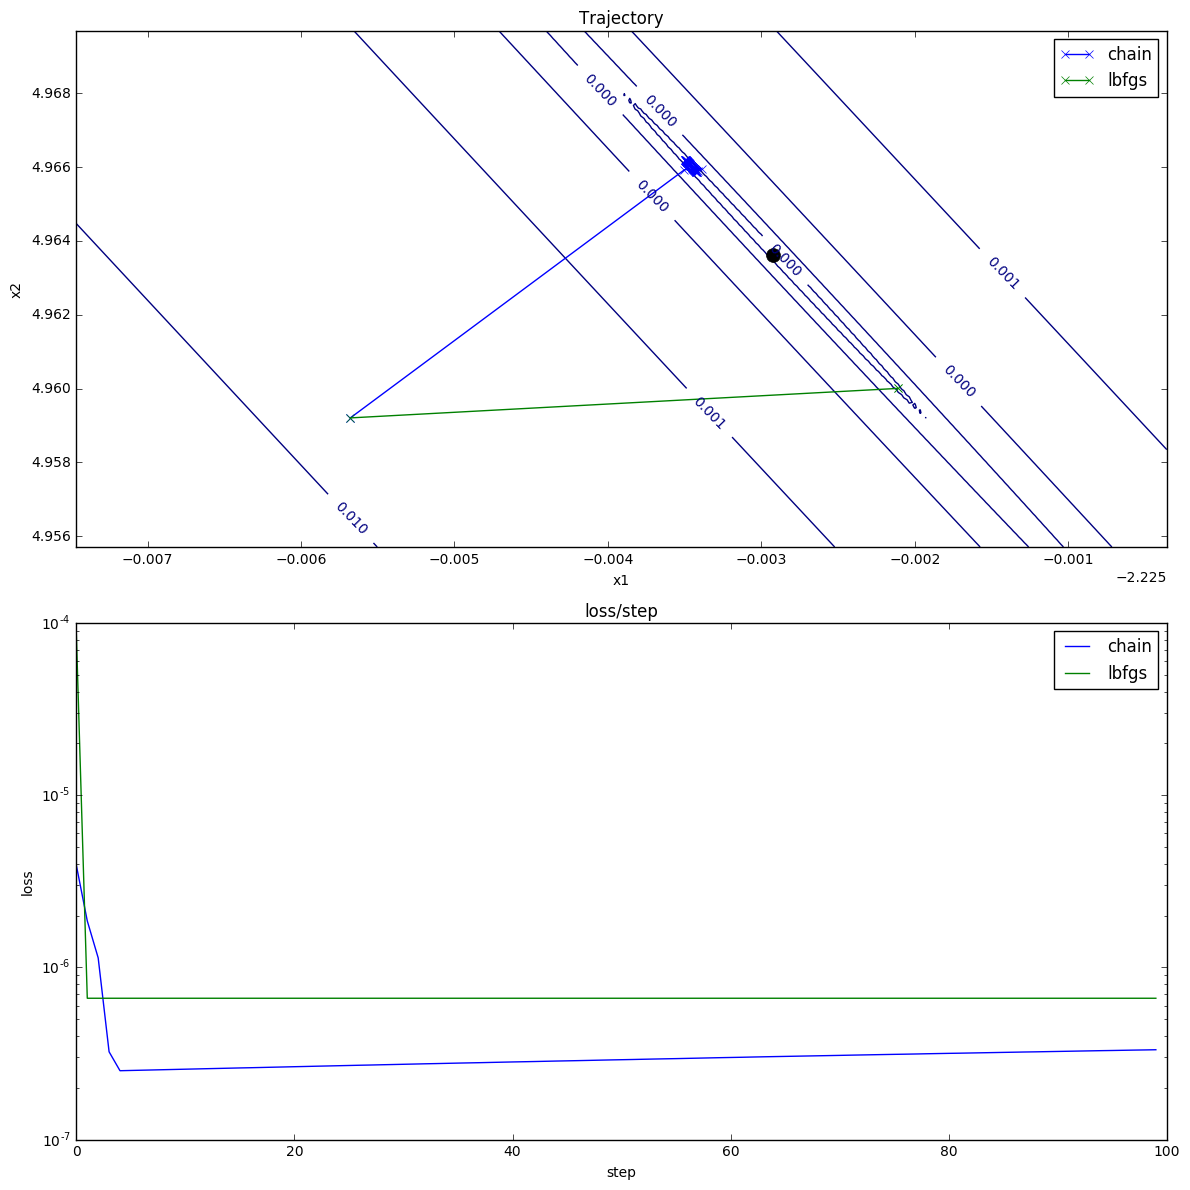

In [33]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point_second_phase), lstm_optimizers, {k: v for k, v in non_lstm_optimizers.items() if k == 'lbfgs'})